# Atom Grids

[AtomGrid](https://grid.qcdevs.org/pyapi/grid.atomgrid.html#grid.atomgrid.AtomGrid) constructs an atomic grid by combining a radial and angular components for evaluation, integration, interpolation, and differentiation in three-dimensional (3D) space. In quantum chemistry, this is typically used for computations of atomic properties. However, this is a general purpose grid that can be used for any function in 3D space.

This notebook showcases various functionalities of [AtomGrid](https://grid.qcdevs.org/pyapi/grid.atomgrid.html#grid.atomgrid.AtomGrid). For computing properties on the grid, we use $\textbf{He}$ in the triplet state ($1s^1 2s^1$) as an example. The corresponding wavefunction is obtained from formatted checkpoint file `"doc/notebooks/He_t.fchk"`. The [`qc-iodata`](https://github.com/theochem/iodata) package is used for parsing the wavefuction data from the fchk file, and [`qc-gbasis`](https://github.com/theochem/gbasis) package is used for analytical evaluation of various properties in the grid.


In [10]:
from iodata import load_one

# Get the atomic coordinates array to use as the center of the grid
mol = load_one("He_t.fchk")

center = mol.atcoords.flatten()
print(f"Atomic Coordinates: {mol.atcoords}")
print(f"Atomic numbers    : {mol.atnums}")
print(f"Alpha MO occupations: {mol.mo.occsa}")
print(f"Beta MO occupations : {mol.mo.occsb}")

Atomic Coordinates: [[0. 0. 0.]]
Atomic numbers    : [2]
Alpha MO occupations: [1. 1.]
Beta MO occupations : [0. 0.]


## Construct Atomic Grid

There are multiple ways to construct an atomic grid, for a complete description see the [Atomic_Grid_Construction.ipynb]().

Here we construct an atomic grid from a radial grid instance and the degrees of the angular grid centered at the position of $\textbf{He}$ nucleus. The radial grid is constructed by specifying the number of radial grid points. For more details on the radial and angular grids see [Radial_Grid.ipynb]() and [Angular_Grid.ipynb]().


In [12]:
import numpy as np
from grid import GaussLegendre, BeckeRTransform, AtomGrid

# construct a radial grid with 150 points
oned = GaussLegendre(npoints=150)
rgrid = BeckeRTransform(0.0, R=1.5).transform_1d_grid(oned)

print(f"Radial grid size : {rgrid.size}")
print(f"Radial grid r_min: {np.min(rgrid.points):.5f}")
print(f"Radial grid r_max: {np.max(rgrid.points):.5f}\n")

# construct atomic grid
atgrid = AtomGrid(rgrid, degrees=[22], center=center)

# atomic grid size = (radial grid size) * (angular grid size)
print(f"AtomGrid size          : {atgrid.size}")
print(f"AtomGrid points shape  : {atgrid.points.shape}")
print(f"AtomGrid weights shape : {atgrid.weights.shape}")
print(f"AtomGrid radial size   : {atgrid.rgrid.size}")
print(f"AtomGrid angular degree: {atgrid.degrees}")
print(f"AtomGrid center        : {atgrid.center}")

Radial grid size : 150
Radial grid r_min: 0.00010
Radial grid r_max: 23498.50372

AtomGrid size          : 29100
AtomGrid points shape  : (29100, 3)
AtomGrid weights shape : (29100,)
AtomGrid radial size   : 150
AtomGrid angular degree: [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
AtomGrid center        : [0. 0. 0.]


### Example: Integrate Electron Density

To integrate a scalar function over the atomic grid, we first need to evaluate the function on the grid points. Here, we compute the electron density $\rho(\mathbf{r})$ of the $\textbf{He}$ in the triplet state ($1s^1 2s^1$) using the [`gbasis.evals.density`]() function of the [`qc-gbasis`](https://github.com/theochem/gbasis) package. The wavefunction data are loaded from the formatted checkpoint file using [`load_one`](https://iodata.readthedocs.io/en/latest/pyapi/iodata.api.html#iodata.api.load_one) function of [`qc-iodata`](https://github.com/theochem/iodata)package. The density values are then integrated using the [`AtomGrid.integrate`](https://grid.qcdevs.org/pyapi/grid.basegrid.html#grid.basegrid.Grid.integrate) method.


In [13]:
from gbasis.wrappers import from_iodata
from gbasis.evals.density import evaluate_density

# Check that the atomic grid is centered at the position of atomic nucleus
assert np.all(mol.atcoords == atgrid.center)

# Construct molecular basis from wave-function information read by IOData
basis, type = from_iodata(mol)

# Evaluate the electron density on the grid points
rdm = mol.one_rdms["scf"]
dens = evaluate_density(rdm, basis, atgrid.points, coord_type=type)
print(f"Shape of electron density array : {dens.shape}")

# Integrate electron density
print(f"Number of electrons in molecule : {np.sum(mol.atnums) - mol.charge}")
print(f"Integral of the electron density: {atgrid.integrate(dens)}")

Shape of electron density array : (29100,)
Number of electrons in molecule : 2.0
Integral of the electron density: 1.9999999911143622


### Example: Calculate Radial Electron Density Distribution

The radial distribution of the electron density describes the probability of finding an electron in the spherical shell between $r$ and $r + dr$. This is calculated by integrating the electron density over the angular coordinates.

$$\rho(r) = \int_\theta \int_\phi \rho(r, \theta, \phi) r^{2} sin(\phi) d\theta d\phi$$

The $r^{2} sin(\phi)$ in the integral is added because the electron density is defined in spherical coordinates and the volume element is given by $dV = r^{2} sin(\phi) dr d\theta d\phi$. This integral can be written as a sum over the grid points:

$$\rho(r_i) = r_{i}^{2}  \int  \int  \rho(r_{i}, \theta, \phi)sin(\phi) d\theta d\phi$$

where $r_i$ is a radial grid point.

Here we calculate the radial electron density distribution for the $\textbf{He}$ atom in the triplet ($1s^2 2s^1$) state using the previously defined atomic grid and the electron density values calculated on the grid points.


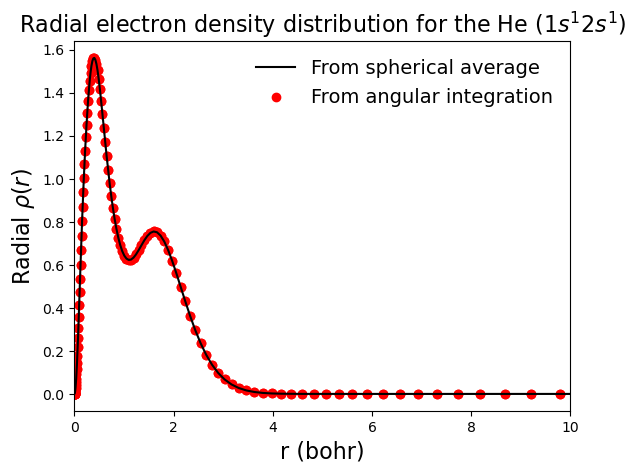

Max difference between the radial electron density obtained from the angular integration
and the spherical average: 2.220446049250313e-16


In [18]:
import matplotlib.pyplot as plt

# Compute the radial electron density distribution
radial_dens = atgrid.integrate_angular_coordinates(dens)
radial_dens *= rgrid.points**2

# define radial electron density function from spherical average interpolation
radial_dens_func = lambda r: (4 * np.pi * atgrid.spherical_average(dens)(r)) * r**2

# plot the radial electron density
y_axis = radial_dens
x_axis = rgrid.points

plt.title("Radial electron density distribution for the He $(1s^{1}2s^{1})$", fontsize=16)
plt.plot(x_axis, radial_dens_func(x_axis), color='black', label='From spherical average')
plt.scatter(x_axis, y_axis, color='red', marker='o', label='From angular integration')
plt.scatter(x_axis, y_axis, color="red", marker="o")
plt.xlabel("r (bohr)", fontsize=16)
plt.ylabel(r"Radial $\rho(r)$", fontsize=16)
plt.xlim(0, 10)
plt.legend(frameon=False, fontsize=14)
plt.show()

# compare the radial electron density obtained from the angular integration an angular average
print(f"Max difference between the radial electron density obtained from the angular integration\n"
        f"and the spherical average: {np.max(np.abs(radial_dens_func(x_axis) - y_axis))}")

The maximum values of the radial electron density distribution corresponds to the radial position with maximum probability of finding an electron. In this case there are two maximum values corresponding to the two electrons. The first one (left to right) corresponds to the $1s$ orbital and the second one to the $2s$ orbital. The radial electron density distribution also integrates to the total number of electrons in the system.


In [19]:
print(f"Number of electrons in atom            : {np.sum(mol.atnums) - mol.charge}")
print(f"Integral of the radial electron density: {rgrid.integrate(radial_dens)}")

Number of electrons in atom            : 2.0
Integral of the radial electron density: 1.9999999911143642


### Example: Calculate Classical Coulomb Repulsion Energy

The classical Coulomb repulsion energy $\mathbf{J}$ is defined as:

$$\mathbf{J} = \frac{1}{2} \int \int \frac{\rho(\mathbf{r}) \rho(\mathbf{r}')}{|\mathbf{r} - \mathbf{r}'|} d\mathbf{r} d\mathbf{r}'$$

where $\rho(\mathbf{r})$ is the electron density at point $\mathbf{r}$. This double integral can be rewritten as a double sum over grids $\text{G}_1$ and $\text{G}_2$ each with sizes $N_{\text{G}_1}$ and $N_{\text{G}_2}$ respectively:

$$E_{rep} = \frac{1}{2} \sum_{i}^{N_{\text{G}_1}} \sum_{j}^{N_{\text{G}_2}} \frac{w(\mathbf{r}_i)\rho(\mathbf{r}_i) w(\mathbf{r}_j)\rho(\mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|}$$

where $\mathbf{r}$ and $w(\mathbf{r})$ represent the coordinates and weights of grid points.
When $i = j$, the denominator is zero denominator and the energy is undefined. To ensure that grid points do not coincide, different grids are used for $\mathbf{r}_i$ and $\mathbf{r}_j$ within the same spatial domain. This can be easily done by introducing a second atomic grid with different angular degree or one less radial grid points. The electron density values on this second grid can be either directly computed or obtained by interpolating from the values on the first grid using the [`AtomGrid.interpolate`](https://grid.qcdevs.org/pyapi/grid.atomgrid.html#grid.atomgrid.AtomGrid.interpolate) method.


In [20]:
# Construct another radial grid with one less point
oned = GaussLegendre(npoints=atgrid.rgrid.size - 1)
rgrid = BeckeRTransform(0.0, R=1.5).transform_1d_grid(oned)

# Construct the second atomic grid (i.e., auxiliary grid) with the same angular degree
atgrid_aux = AtomGrid(rgrid, degrees=[23])

# interpolate the electron density on the auxiliary atomic gird points
func_interpolate_dens = atgrid.interpolate(dens)
dens_aux = func_interpolate_dens(atgrid_aux.points)

classic_coulomb = 0.0
# loop over grid points in the first grid
for i in range(atgrid.size):
    # compute its distance to all the points in the auxiliary atomgrid
    distances = np.linalg.norm(atgrid.points[i] - atgrid_aux.points, axis=1)
    # compute its Coulomb repulsion with the electron density at the auxiliary atomgrid points
    coulomb_points = atgrid.weights[i] * dens[i] * dens_aux / distances / 2
    classic_coulomb += atgrid_aux.integrate(coulomb_points)

print(f"Classic Coulomb Energy : {classic_coulomb} (hartree)")

Classic Coulomb Energy : 1.772374684606753 (hartree)
